In [46]:
import librosa
import json
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

import speech_recognition as sr 
from pydub import AudioSegment
from pydub.silence import split_on_silence

import keras
from sklearn.model_selection import train_test_split

In [47]:
JSON_PATH_TRAIN = "data_10.json" 
JSON_PATH_TEST="test_10.json"
DATASET_PATH ="./train_data/"  
# path of directory which contain training audios
t_audio="./test_data/test_audio.wav" 
# path of test_file
song="./test_data"
# path of directory which contain test audios

file_names=[]
audio_names=[]

In [48]:
def plot_history(history):  #graphs train and test 
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [49]:
SAMPLE_RATE = 1000
TRACK_DURATION = 179 # measured in seconds  var_2
num_segments=179
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
# sample length = 1ms

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=500,hop_length=250,num_segments=num_segments): #***
    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
     
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    # loop through all genre sub-folder
    for (dirpath,dirnames,filenames) in os.walk(dataset_path):
            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
            # process all audio files in genre sub-dir
            j=0
            for f in filenames:
                file_names.append(f)
                file_path = os.path.join(dirpath, f)
                audio_names.append(file_path)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                # process all segments of audio file
                for d in range(num_segments):
                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr = sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment+1:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(j)
                        #print("{}, segment:{}".format(file_path, d+1))
                j=j+1
    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp,indent=4)

In [50]:
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH_TRAIN, num_segments=179)


Processing: 


In [51]:
DATA_PATH = JSON_PATH_TRAIN 
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    #print(X[0])
    print("Data succesfully loaded!")

    return  X, y

# Model training

Data succesfully loaded!
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 65)                0         
                                                                 
 dense_23 (Dense)            (None, 128)               8448      
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 2)                 66        
                                                                 
Total params: 18,850
Trainable params: 18,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [========

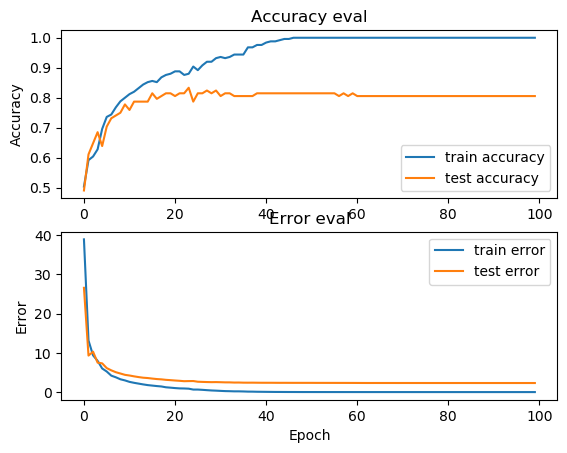

['audio_class_1.wav', 'audio_class_2.wav']

Processing: test_data
Data succesfully loaded!
1/1 [==============================] - 0s 30ms/step
pridicted values of segments : 
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1] 

indices of persons in the given audio are: [1, 0, 1] 

start timings of respective persons are : [1, 61, 88] 



1) from 0.0sec to 61.0sec is spoken by: audio_class_1.wav 

audio_class_1.wav:
Could not understand audio 31 new years new Wari Could not understand audio Could not understand audio Could not understand audio 

2) from 61.0sec to 88.0sec is spoken by: audio_class_2.wav 

audio_class_2.wav:
cross forest Could not understand audio Could not understand audio 

In [52]:
if __name__ == "__main__":

    ### 3) training the model using keras ###
    
    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # build network topology
    #multi layer model
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(128, activation='relu'),

        # 2nd dense layer
        keras.layers.Dense(64, activation='relu'),

        # 3rd dense layer
        keras.layers.Dense(32, activation='relu'),

        # output layer
        keras.layers.Dense(2, activation='softmax')
    ])

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

    # plot accuracy and error as a function of the epochs
    plot_history(history)
    num_segments=89    #adjust no of segments of given audio      var_3
    SAMPLE_RATE = 1000
    TRACK_DURATION = 89 # measured in seconds                      var_4
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
    samples_per_segment = int(SAMPLES_PER_TRACK /TRACK_DURATION)
    print(file_names)
    save_mfcc(song,JSON_PATH_TEST,num_segments=num_segments)
    X,y=load_data(JSON_PATH_TEST)
    prid_values=[]
    for d in range(num_segments):
        seg_array=X[d]
        mfcc=np.reshape(seg_array,(1,5,13))
        pridiction=model.predict(mfcc) 
        pridiction=pridiction.tolist()
        max_val=max(pridiction[0])
        out_put=pridiction[0].index(max_val)
        prid_values.append(out_put)
    print("pridicted values of segments : \n {} \n".format(prid_values))
    
    init_seg_prid=prid_values[0]
    audio_sep_n=[]
    audio_sep_t=[]
    j=0
    for i in prid_values:
        if i!=init_seg_prid and j<=(len(prid_values)-3):
            if prid_values[j]==prid_values[j+1] and prid_values[j]==prid_values[j+2]: 
                audio_sep_t.append(j)
                audio_sep_n.append(init_seg_prid)
                init_seg_prid=prid_values[j]
        j=j+1
    audio_sep_t.append(len(prid_values)-1)
    audio_sep_n.append(prid_values[audio_sep_t[len(audio_sep_t)-2]])
    print("indices of persons in the given audio are: {} \n".format(audio_sep_n))
    print("start timings of respective persons are : {} \n".format(audio_sep_t)) 
    
    ### 6) decoding the audios using speech recogniser and pydub ###
    T1=0
    l=1
    for i in range(len(audio_sep_n)):
        T2=(audio_sep_t[i])*1000
        if ((T2-T1)/1000)>=10:
            second_of_silence = AudioSegment.silent(2000) 
            ekaAudio = AudioSegment.from_wav(t_audio)
            ekaAudio = ekaAudio[T1:T2]
            ekaAudio=second_of_silence+ekaAudio+second_of_silence
            ekaAudio.export('ekaSong{}.wav'.format(i),format="wav") #Exports to a wav file in the current path.
            k=0
            chunk_audio= AudioSegment.from_wav('ekaSong{}.wav'.format(i))
            print("\n")
            print("{}) from {}sec to {}sec is spoken by: {} \n".format(l,T1/1000,T2/1000,file_names[audio_sep_n[i]]))
            print("{}:".format(file_names[audio_sep_n[i]]))
            T1=T2
            # split track where silence is 0.5 seconds 
            # or more and get chunks
            chunks = split_on_silence(chunk_audio,
                # must be silent for at least 0.5 seconds
                # or 500 ms. adjust this value based on user
                # requirement. if the speaker stays silent for 
                # longer, increase this value. else, decrease it.
                min_silence_len = 500,

                # consider it silent if quieter than -16 dBFS
                # adjust this per requirement
                silence_thresh = -50
            )
            # process each chunk
            l=l+1
            for chunk in chunks:

                # Create 0.5 seconds silence chunk
                chunk_silent = AudioSegment.silent(duration = 10)

                # add 0.5 sec silence to beginning and 
                # end of audio chunk. This is done so that
                # it doesn't seem abruptly sliced.
                audio_chunk = chunk_silent + chunk + chunk_silent

                # export audio chunk and save it in 
                # the current directory.
                #print("saving chunk{0}.wav".format(k))
                audio_chunk.export("./chunk{0}.wav".format(k), bitrate ='192k', format ="wav")

                # the name of the newly created chunk
                filename = 'chunk'+str(k)+'.wav'

                #print("Processing chunk "+str(k))

                # get the name of the newly created chunk
                # in the AUDIO_FILE variable for later use.
                file = filename

                # create a speech recognition object
                r = sr.Recognizer()

                # recognize the chunk
                with sr.AudioFile(file) as source:
                    # remove this if it is not working
                    # correctly.
                    r.adjust_for_ambient_noise(source)
                    audio_listened = r.listen(source)

                try:
                    # try converting it to text
                    rec = r.recognize_google(audio_listened)
                    # write the output to the file.
                    print(rec,end=" ")

                # catch any errors.
                except sr.UnknownValueError:
                    print("Could not understand audio",end=" ")

                except sr.RequestError as e:
                    print("Could not request results. check your internet connection")

                k=k+1
            if ((T2-T1)/1000)>=10:
                fh.write("\n")
                print("\n")